In [3]:
import pandas as pd
df = pd.read_excel("data/metaanalysis_data.xlsx")

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Study                                      27 non-null     object 
 1   Female authors                             27 non-null     int64  
 2   Male authors                               27 non-null     int64  
 3   Age (months)                               27 non-null     float64
 4   N_boys                                     27 non-null     int64  
 5   N_girls                                    27 non-null     int64  
 6   Mean_boys_play_male                        27 non-null     float64
 7   SD_boys_play_male                          27 non-null     float64
 8   Mean_girls_play_male                       27 non-null     float64
 9   SD_girls_play_male                         27 non-null     float64
 10  Mean_boys_play_female       

,Study,Female authors,Male authors,Age (months),N_boys,N_girls,Mean_boys_play_male,SD_boys_play_male,Mean_girls_play_male,SD_girls_play_male,...,Country,Case definition adequate,Representativeness of cases,Selection of controls,Parental opinion,Comparability of both groups,Ascertainment of behaviour,Same ascertainment method for both groups,Non‐response rate,NOS score
0,Alexander & Saenz (2012),2,0,19.50,47,47,438.72,166.08,248.64,161.28,...,0.256,*,*,X,X,*,*,*,X,5
1,Arthur (2014),1,0,19.00,22,18,148.00,105.00,54.00,53.00,...,0.280,*,X,X,X,**,*,*,*,6
2,Berenbaum & Hines (1992),2,0,65.79,18,18,325.25,270.21,135.13,201.72,...,0.252,X,*,*,*,*,*,*,X,6
3,Berenbaum & Snyder (1995),2,0,93.10,19,19,484.21,141.28,202.48,168.14,...,0.252,*,X,*,*,*,*,*,*,7
4,Doering et al (1989),1,3,87.00,15,15,260.10,67.70,98.40,101.30,...,0.141,*,*,*,X,*,*,*,X,6


In [5]:
import numpy as np
import pandas as pd

def calculate_cohens_d(row, toy_type):
    if toy_type == "male":
        mean1, sd1 = row['Mean_boys_play_male'], row['SD_boys_play_male']
        mean2, sd2 = row['Mean_girls_play_male'], row['SD_girls_play_male']
    elif toy_type == "female":
        mean1, sd1 = row['Mean_boys_play_female'], row['SD_boys_play_female']
        mean2, sd2 = row['Mean_girls_play_female'], row['SD_girls_play_female']
    
    n1, n2 = row['N_boys'], row['N_girls']
  
    pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2 - 2))

    d = (mean1 - mean2) / pooled_sd

    var_d = (n1 + n2)/(n1 * n2) + (d**2)/(2*(n1 + n2))
    
    return pd.Series({'d': d, 'var_d': var_d})

df[['d_male', 'var_d_male']] = df.apply(lambda x: calculate_cohens_d(x, "male"), axis=1)
df[['d_female', 'var_d_female']] = df.apply(lambda x: calculate_cohens_d(x, "female"), axis=1)

print(df[['Study', 'd_male', 'var_d_male', 'd_female', 'var_d_female']].head())

                       Study    d_male  var_d_male  d_female  var_d_female
0   Alexander & Saenz (2012)  1.161166    0.049725 -0.832679      0.046241
1              Arthur (2014)  1.096481    0.116038 -1.917929      0.146991
2   Berenbaum & Hines (1992)  0.797359    0.119941 -1.183997      0.130581
3  Berenbaum & Snyder (1995)  1.814197    0.148570 -1.311721      0.127903
4       Doering et al (1989)  1.876874    0.192044 -1.747367      0.184222


Boys played significantly longer with male-typed toys (all *d* > 0.8, large effects).
Girls played significantly longer with female-typed toys (all *d* < -0.8, large effects).
Consistency: Results align with stereotypical gender preferences across all studies.

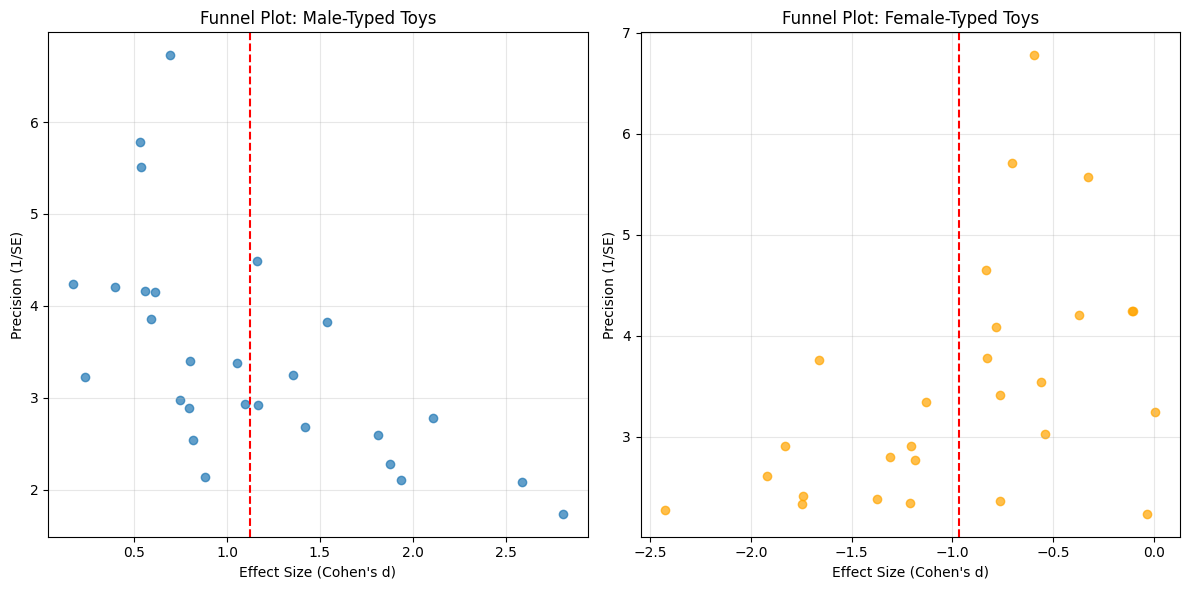

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots
plt.figure(figsize=(12, 6))

# --- Male-Typed Toys Funnel Plot ---
plt.subplot(1, 2, 1)
# Calculate standard error from variance
df['se_male'] = np.sqrt(df['var_d_male'])
# Plot effect size vs precision
plt.scatter(df['d_male'], 1/df['se_male'], alpha=0.7)
plt.axvline(x=df['d_male'].mean(), color='red', linestyle='--')
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Precision (1/SE)')
plt.title('Funnel Plot: Male-Typed Toys')
plt.grid(True, alpha=0.3)

# --- Female-Typed Toys Funnel Plot ---
plt.subplot(1, 2, 2)
df['se_female'] = np.sqrt(df['var_d_female'])
plt.scatter(df['d_female'], 1/df['se_female'], alpha=0.7, color='orange')
plt.axvline(x=df['d_female'].mean(), color='red', linestyle='--')
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Precision (1/SE)')
plt.title('Funnel Plot: Female-Typed Toys')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
import statsmodels.api as sm
import pandas as pd

# 1. Handle missing values (drop rows with missing Country)
df_clean = df.dropna(subset=['Country']).copy()

# 2. Create scaled variables (using original column names)
df_clean['GII_scaled'] = (df_clean['Country'] - df_clean['Country'].mean()) / df_clean['Country'].std()
df_clean['NOS_scaled'] = (df_clean['NOS score'] - df_clean['NOS score'].mean()) / df_clean['NOS score'].std()

# 3. PROPER WAY to handle spaces in formula:
formula = """d_male ~ 1 + NOS_scaled + C(Setting) + GII_scaled + Q("Parent present")"""

# 4. Run meta-regression
model2 = sm.MixedLM.from_formula(
    formula,
    groups=df_clean["Study"],
    vc_formula={"var_d_male": "0 + var_d_male"},
    data=df_clean
)
result2 = model2.fit()

print("\n=== Model Results ===")
print(result2.summary())


=== Model Results ===
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   d_male  
No. Observations:     26        Method:               REML    
No. Groups:           15        Scale:                0.0795  
Min. group size:      1         Log-Likelihood:       -21.3820
Max. group size:      4         Converged:            Yes     
Mean group size:      1.7                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.503    0.497  3.026 0.002  0.530  2.477
C(Setting)[T.2]     -0.104    0.382 -0.273 0.784 -0.852  0.643
C(Setting)[T.3]     -0.544    0.579 -0.939 0.348 -1.679  0.592
NOS_scaled          -0.223    0.117 -1.901 0.057 -0.453  0.007
GII_scaled          -0.023    0.143 -0.158 0.874 -0.303  0.258
Q("Parent present") -0.321    0.132 -2.426 0.

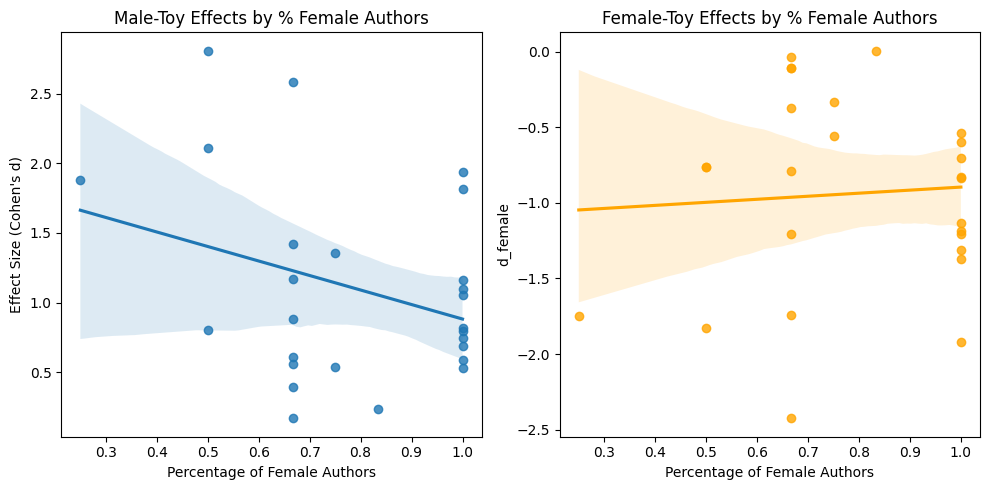


=== Does Author Gender Affect Male-Toy Results? ===
            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   d_male  
No. Observations:     26        Method:               REML    
No. Groups:           15        Scale:                0.0854  
Min. group size:      1         Log-Likelihood:       -20.7931
Max. group size:      4         Converged:            Yes     
Mean group size:      1.7                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.694    0.671  2.524 0.012  0.378  3.009
C(Setting)[T.2]     -0.067    0.396 -0.169 0.866 -0.843  0.709
C(Setting)[T.3]     -0.492    0.603 -0.815 0.415 -1.674  0.691
female_author_pct   -0.289    0.665 -0.435 0.663 -1.592  1.014
NOS_scaled          -0.237    0.124 -1.916 0.055 -0.480  0.005
GII_scaled     

In [21]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare author gender variables
df_clean['female_author_pct'] = df_clean['Female authors'] / (df_clean['Female authors'] + df_clean['Male authors'])

# 2. Visualization: Effect sizes by author gender composition
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.regplot(x='female_author_pct', y='d_male', data=df_clean)
plt.title('Male-Toy Effects by % Female Authors')
plt.xlabel('Percentage of Female Authors')
plt.ylabel('Effect Size (Cohen\'s d)')

plt.subplot(1, 2, 2)
sns.regplot(x='female_author_pct', y='d_female', data=df_clean, color='orange')
plt.title('Female-Toy Effects by % Female Authors')
plt.xlabel('Percentage of Female Authors')

plt.tight_layout()
plt.show()

# 3. Meta-Regression Analysis
print("\n=== Does Author Gender Affect Male-Toy Results? ===")
model_male = sm.MixedLM.from_formula(
    """d_male ~ 1 + female_author_pct + NOS_scaled + C(Setting) + GII_scaled + Q("Parent present")""",
    groups=df_clean["Study"],
    vc_formula={"var_d_male": "0 + var_d_male"},
    data=df_clean
)
result_male = model_male.fit()
print(result_male.summary())

print("\n=== Does Author Gender Affect Female-Toy Results? ===")
model_female = sm.MixedLM.from_formula(
    """d_female ~ 1 + female_author_pct + NOS_scaled + C(Setting) + GII_scaled + Q("Parent present")""",
    groups=df_clean["Study"],
    vc_formula={"var_d_female": "0 + var_d_female"},
    data=df_clean
)
result_female = model_female.fit()
print(result_female.summary())

# 4. Binary Analysis (All-Female vs Mixed/All-Male Teams)
df_clean['all_female'] = (df_clean['Male authors'] == 0).astype(int)

print("\n=== All-Female vs Other Teams ===")
print("Male-Toy Effects:")
print(df_clean.groupby('all_female')['d_male'].describe())
print("\nFemale-Toy Effects:")
print(df_clean.groupby('all_female')['d_female'].describe())